In [6]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from src.preprocess import split_improvements, parse_improvement, clean_text
from src.labels import labels_measure


In [7]:
# adjust filename to any EPC CSV you’ve got
df = pd.read_csv("../data/raw/D_EPC_data_2025Q2/2025Q2.csv", nrows=200_000, low_memory=False)

# explode 'IMPROVEMENTS' into rows
records = []
for raw in df["IMPROVEMENTS"].dropna():
    for seg in split_improvements(raw):
        rec = parse_improvement(seg)
        if rec["measure"]:
            rec["label"] = labels_measure(rec["measure"])
            records.append(rec)

imp = pd.DataFrame(records)
imp = imp.dropna(subset=["label"]).reset_index(drop=True)
imp["clean"] = imp["measure"].map(clean_text)
imp.head()


,measure,cost,saving,rating,raw,label,clean
0,Floor insulation (suspended floor),"£800 - £1,200",69.0,C,Description: Floor insulation (suspended floor...,{insulation},floor insulation suspended floor
1,Solar water heating,"£4,000 - £6,000",45.0,C,Description: Solar water heating; Indicative C...,{renewables},solar water heating
2,"Solar photovoltaic panels, 2.5 kWp","£3,500 - £5,500",425.0,B,"Description: Solar photovoltaic panels, 2.5 kW...",{renewables},solar photovoltaic panels kwp
3,Replacement glazing units,"£1,000 - £1,400",56.0,C,Description: Replacement glazing units; Indica...,{glazing},replacement glazing units
4,Cavity wall insulation,"£500 - £1,500",88.0,C,Description: Cavity wall insulation; Indicativ...,{insulation},cavity wall insulation


In [4]:
imp['raw'][0]

'Description: Floor insulation (suspended floor); Indicative Cost: £800 - £1,200; Typical Saving: 69; Energy Rating after improvement: C 75; Environmental Rating after improvement: C 74; Green Deal Eligible: Y'

In [3]:
imp["label"].value_counts()

label
{insulation}               61001
{renewables}               54587
{heating}                  10209
{lighting}                  9433
{glazing}                   5690
{hot_water, heating}        3392
{}                          2286
{hot_water}                 1302
{hot_water, insulation}      938
Name: count, dtype: int64

Classes: ['glazing', 'heating', 'hot_water', 'insulation', 'lighting', 'renewables']
              precision    recall  f1-score   support

     glazing       1.00      1.00      1.00      1124
     heating       1.00      1.00      1.00      2686
   hot_water       1.00      1.00      1.00      1137
  insulation       1.00      1.00      1.00     12486
    lighting       1.00      1.00      1.00      1844
  renewables       1.00      1.00      1.00     10898

   micro avg       1.00      1.00      1.00     30175
   macro avg       1.00      1.00      1.00     30175
weighted avg       1.00      1.00      1.00     30175
 samples avg       1.00      1.00      1.00     30175



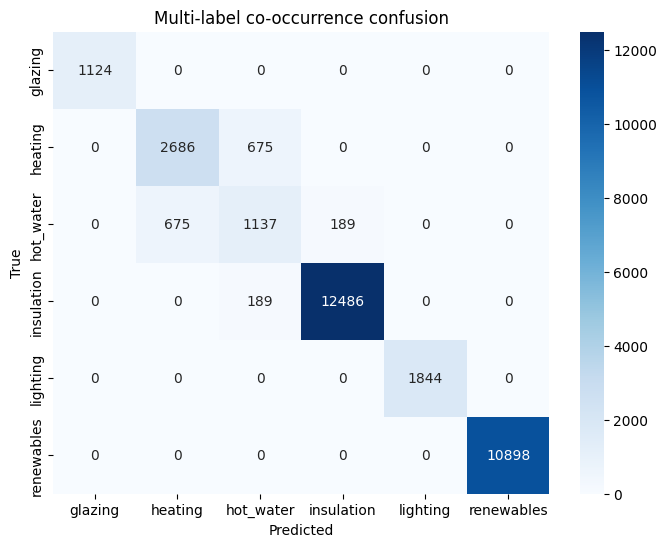

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Binarise multi-label targets
mask = imp["label"].map(len) > 0
imp = imp[mask].copy()


mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(imp["label"])   # imp["labels"] is a set per row
X = imp["clean"]

# Simple split (no stratify)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

multi_clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=8000, ngram_range=(1,2))),
    ("ovr", OneVsRestClassifier(LogisticRegression(max_iter=400, class_weight="balanced")))
])

multi_clf.fit(X_train, Y_train)
Y_pred = multi_clf.predict(X_test)

print("Classes:", list(mlb.classes_))
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))



# build co-occurrence counts: true label vs predicted label
classes = mlb.classes_
cooc = np.zeros((len(classes), len(classes)), dtype=int)

for yt, yp in zip(Y_test, Y_pred):
    true_labels = np.where(yt==1)[0]
    pred_labels = np.where(yp==1)[0]
    for t in true_labels:
        for p in pred_labels:
            cooc[t, p] += 1

plt.figure(figsize=(8,6))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Multi-label co-occurrence confusion")
plt.show()



In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# Binarise multi-label targets
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(imp["label"])   # imp["labels"] is a set per row
X = imp["clean"]

# Simple split (no stratify)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=8000, ngram_range=(1,2))),
    ("ovr", OneVsRestClassifier(LogisticRegression(max_iter=400, class_weight="balanced")))
])


clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred))

ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred), display_labels=clf.classes_).plot(cmap="Blues")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1107
           1       1.00      1.00      1.00      2625
           2       1.00      1.00      1.00      1117
           3       1.00      1.00      1.00     12552
           4       1.00      1.00      1.00      1874
           5       1.00      1.00      1.00     10908

   micro avg       1.00      1.00      1.00     30183
   macro avg       1.00      1.00      1.00     30183
weighted avg       1.00      1.00      1.00     30183
 samples avg       0.99      0.99      0.99     30183



/home/federicostachurski/epc-nlp-project/.npl_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/federicostachurski/epc-nlp-project/.npl_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/federicostachurski/epc-nlp-project/.npl_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior

ValueError: multilabel-indicator is not supported

In [6]:
clf.predict(["replace boiler with condensing boiler and add heating controls"])

array(['heating'], dtype=object)